# PEAK3 Modelling

## Initialisation

In [1]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import * 

import matplotlib.pyplot as plt
import roadrunner
import numpy as np
import pandas as pd

## Basic Model between 14-3-3 and Grb2

In [9]:
model = ModelBuilder('PEAK3_Simple_1')
model.add_reaction(Reaction(mass_action_21, ('PEAK3', 'Grb2'), ('PEAK3_Grb2',)))
model.add_reaction(Reaction(mass_action_21, ('PEAK3', 'Four'), ('PEAK3_Four',)))
model.precompile()


In [10]:
print(model.get_antimony_model())

model PEAK3_Simple_1

J0: PEAK3 + Grb2 -> PEAK3_Grb2; J0_ka*PEAK3*Grb2
J0r: PEAK3_Grb2 -> PEAK3 + Grb2; J0_kd*PEAK3_Grb2
J1: PEAK3 + Four -> PEAK3_Four; J1_ka*PEAK3*Four
J1r: PEAK3_Four -> PEAK3 + Four; J1_kd*PEAK3_Four

# State variables in the system
PEAK3=100
Grb2=100
PEAK3_Grb2=0
Four=100
PEAK3_Four=0

# Parameters in the system
J0_ka=0.001
J0_kd=0.01
J1_ka=0.001
J1_kd=0.01

# Other variables in the system


end


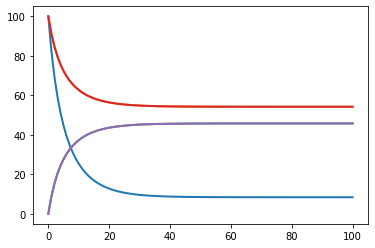

In [11]:
model.simulate(0, 100, 100)
model.plot()

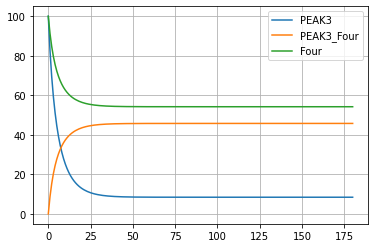

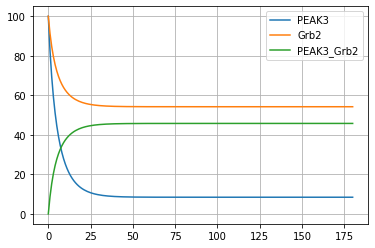

In [14]:
sbml = model.get_sbml_model()
rr = roadrunner.RoadRunner(sbml)

states = model.get_all_variables_keys()
custom_states = model.get_custom_variable_keys()
sim_states = ['time'] + states
res = rr.simulate(0, 180, 180, selections=sim_states)

### VISUALISATION

observable_states = ['PEAK3', 'PEAK3_Four', 'Four']

for state in observable_states:
    plt.plot(res['time'], res[f'{state}'], label=state)

plt.legend()
plt.grid()
plt.show()


observable_states_2 = ['PEAK3', 'Grb2', 'PEAK3_Grb2']

for state in observable_states_2:
    plt.plot(res['time'], res[f'{state}'], label=state)
    
plt.legend()
plt.grid()
plt.show()